In [1]:
import os, re 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

In [42]:
def get_results_dir(model_name, dataset_name, model_type, fault_type):
    d = {
        'vgg16': {
            'cifar10': {
                'full': {
                    'faults': './logs/vgg16/cifar10/faults',
                    'zero_bit_masking':  './logs/vgg16/cifar10/zero_bit_masking',
                    'faults_param': './logs/vgg16/cifar10/faults_param',
                    'faults_layer': './logs/vgg16/cifar10/faults_layer',
                },
                'prune': {
                    'faults': './logs/vgg16/cifar10/prune/scratchB/faults',
                    'zero_bit_masking': './logs/vgg16/cifar10/prune/scratchB/zero_bit_masking',
                    'faults_param_mimic': './logs/vgg16/cifar10/prune/scratchB/faults_param_mimic',
                }
            }
        },
         'resnet56': {
            'cifar10': {
                'full': {
                    'faults': './logs/resnet56/cifar10/faults',
                    'zero_bit_masking':  './logs/resnet56/cifar10/zero_bit_masking',
                    'faults_param': './logs/resnet56/cifar10/faults_param',
                },
                'pruneA': {
                    'faults': './logs/resnet56/cifar10/pruneA/scratchB/faults',
                    'zero_bit_masking': './logs/resnet56/cifar10/pruneA/scratchB/zero_bit_masking',
                    'faults_param_mimic': './logs/resnet56/cifar10/pruneA/scratchB/faults_param_mimic',
                },
                'pruneB': {
                    'faults': './logs/resnet56/cifar10/pruneB/scratchB/faults',
                    'zero_bit_masking': './logs/resnet56/cifar10/pruneB/scratchB/zero_bit_masking',
                    'faults_param_mimic': './logs/resnet56/cifar10/pruneB/scratchB/faults_param_mimic',
                },
                'pruneC': {
                    'faults': './logs/resnet56/cifar10/pruneC/scratchB/faults',
                    'zero_bit_masking': './logs/resnet56/cifar10/pruneC/scratchB/zero_bit_masking',
                    'faults_param_mimic': './logs/resnet56/cifar10/pruneC/scratchB/faults_param_mimic',
                },
                'pruneD': {
                    'faults': './logs/resnet56/cifar10/pruneD/scratchB/faults',
                    'zero_bit_masking': './logs/resnet56/cifar10/pruneD/scratchB/zero_bit_masking',
                    'faults_param_mimic': './logs/resnet56/cifar10/pruneD/scratchB/faults_param_mimic',
                }
                
            }
        }
        
    }
    return d.get(model_name).get(dataset_name).get(model_type).get(fault_type)

def get_fault_free_accuracy(model_name, dataset_name, model_type):
    d = {'vgg16': {
        'cifar10': {
            'full': 0.9388, 
            'prune': 0.9395, 
            'pruneB': 0.935}},
        'resnet56': {
            'cifar10':{
                'full': 0.9269, 
                'pruneA': 0.9331, 
                'pruneB': 0.9339, 
                'pruneC': 0.9308, 
                'pruneD': 0.9306}}
        }
    return d[model_name][dataset_name][model_type]

model_name = 'vgg16'
# model_name = 'resnet56'
dataset_name = 'cifar10'

model_types = ['full']
fault_types = ['faults_layer']
# model_types = ['full', 'prune']
# model_types = ['full', 'pruneA', 'pruneB', 'pruneC', 'pruneD']
# fault_types = ['faults', 'zero_bit_masking']
# fault_types = ['faults']
# fault_types = ['faults_param', 'faults_param_mimic']


In [43]:
def parse_log(log_path):
    # trial: 9, bit_position: 0, n_faults: 1, total_params: 1728, 
    # flipped_bits: 1 (1.808449e-05), changed_params: 1 (5.787037e-04), test_time: 2, test_accuracy: 0.938800
    result = {}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line:
                flipped_bits, changed_params, test_accuracy = 0, 0, None 
                items = line.split(',')
                for item in items:
                    if 'total_params' in item:
                        total_params = int(item.split()[1])
                    if 'changed_params' in item:
                        changed_params = int(item.split()[1])
                    if 'test_accuracy' in item:
                        test_accuracy = float(item.split()[1])
                    if 'trial' in item:
                        trial = int(item.split()[1])
                if test_accuracy:
                    result[trial] = [total_params, changed_params, test_accuracy]
    result = np.asarray([result[trial_id] for trial_id in sorted(result.keys())])
    return result 

def load_results(model_type, fault_type):
    results = {}
    results_dir = get_results_dir(model_name, dataset_name, model_type, fault_type)
    if not results_dir:
        return None 
    
    # ./cifar/l1-norm-pruning/logs/vgg16/cifar10/faults_layer/param-0/bit-0/nbits-1
    param_id_folders = os.listdir(results_dir)
    for param_id_folder in param_id_folders:
        param_id = int(param_id_folder.split('-')[-1])
        param_id_path = os.path.join(results_dir, param_id_folder)
        if param_id not in results:
            results[param_id] = {} 
        # get the bit folder 
        for bit_position_folder in os.listdir(param_id_path):
            bit_position = int(bit_position_folder.split('-')[-1])
            bit_position_path = os.path.join(param_id_path, bit_position_folder)
            if bit_position not in results[param_id]:
                results[param_id][bit_position] = {} 
            # get number of bits folder
            for nbits_folder in os.listdir(bit_position_path):
                nbits = int(nbits_folder.split('-')[-1])
                log_path = os.path.join(bit_position_path, nbits_folder, 'logs.txt')
                if os.path.isfile(log_path):
                    results[param_id][bit_position][nbits] = parse_log(log_path)
    return results 
        
data = {} # model_type -> fault_type -> param_id -> bit_position -> n_bits 
for model_type in model_types:
    data[model_type] = {} 
    for fault_type in fault_types:
        results = load_results(model_type, fault_type)
        if results:
            data[model_type][fault_type] = results 

# print(data)


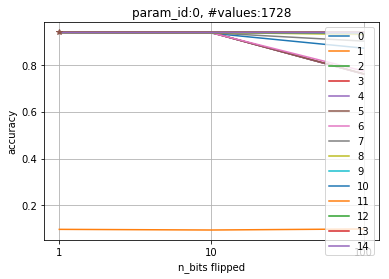

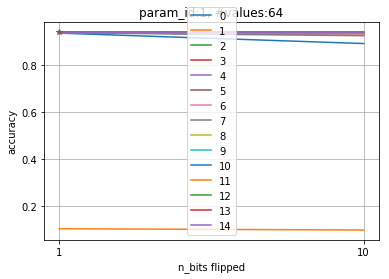

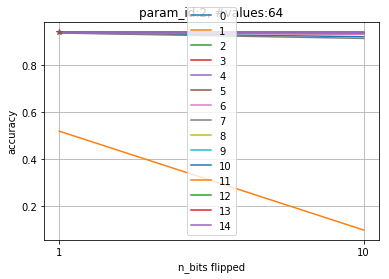

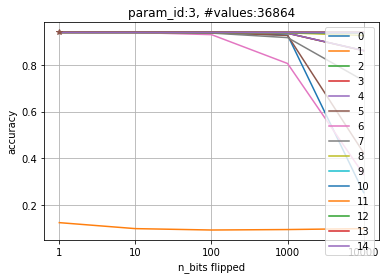

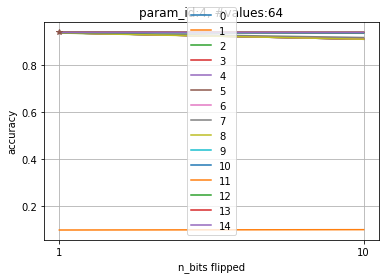

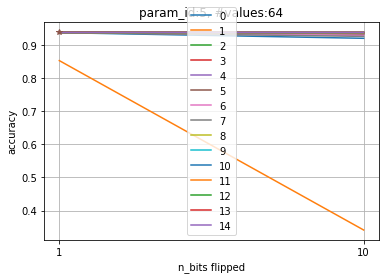

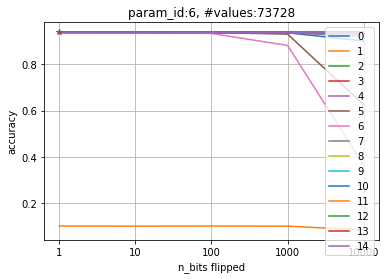

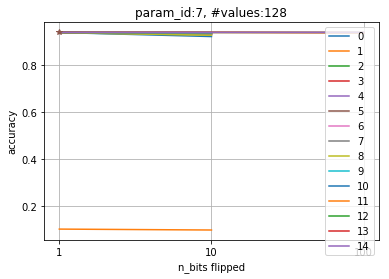

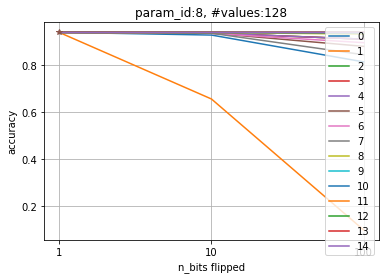

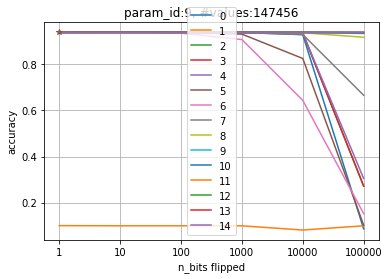

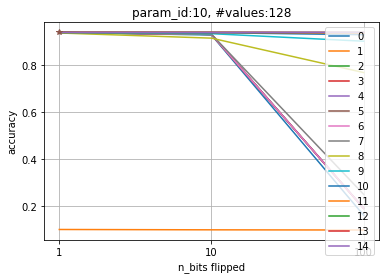

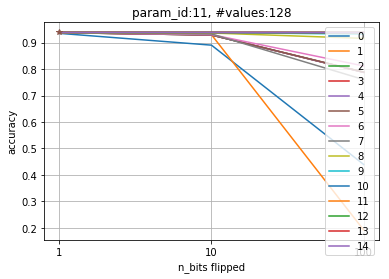

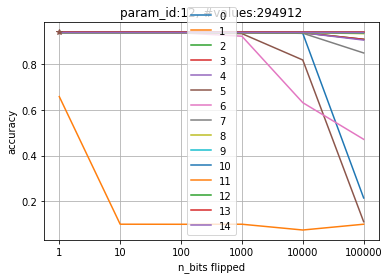

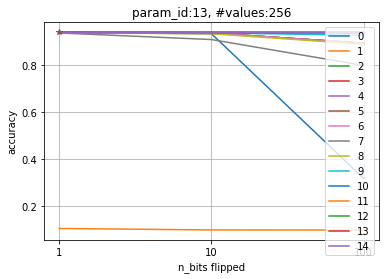

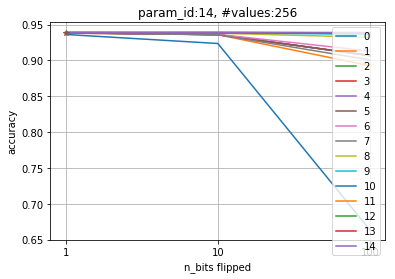

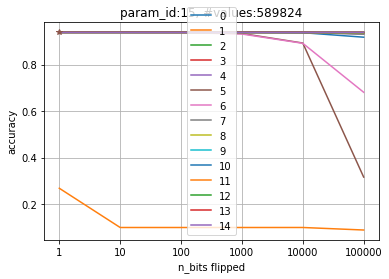

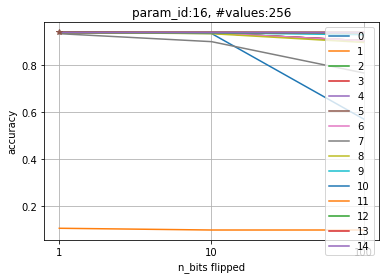

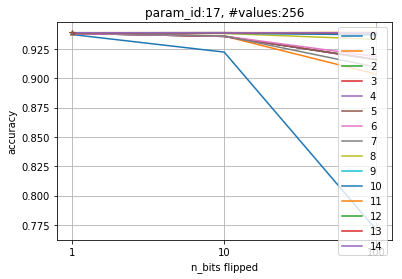

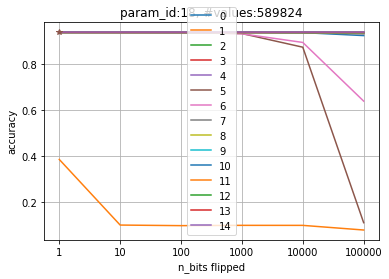

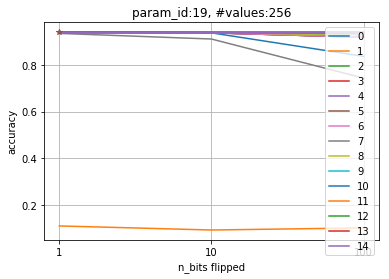

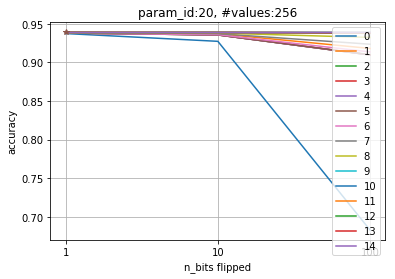

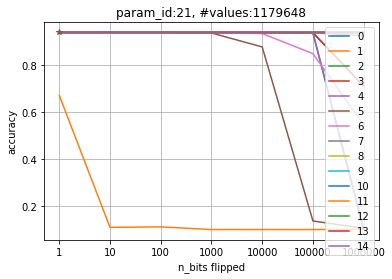

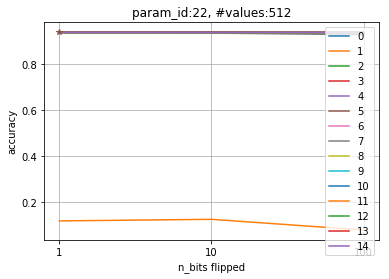

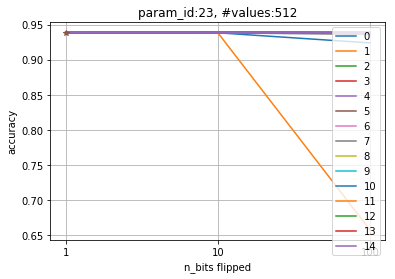

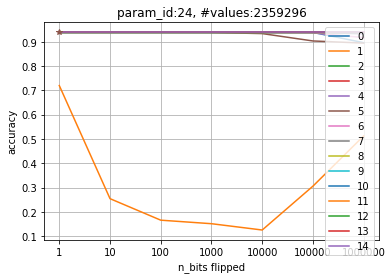

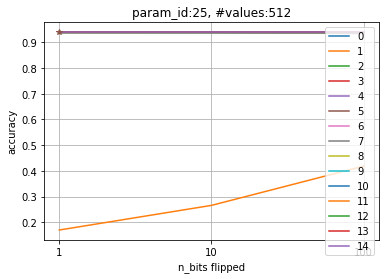

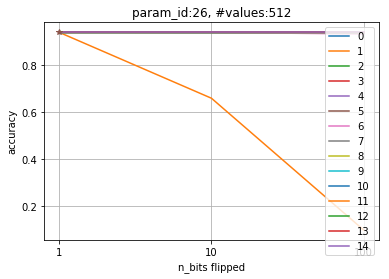

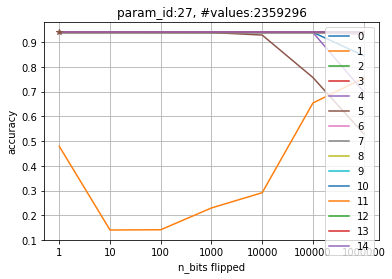

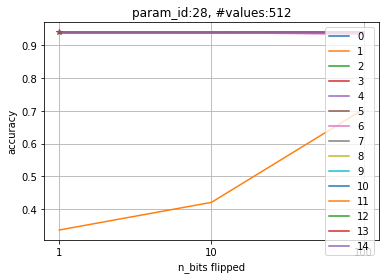

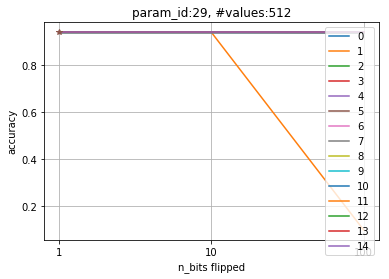

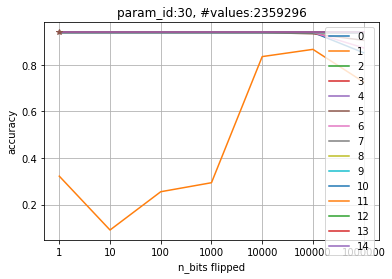

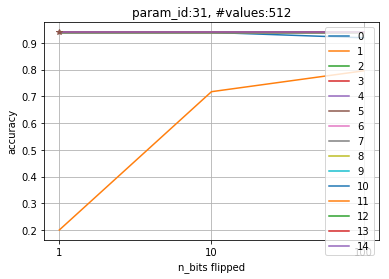

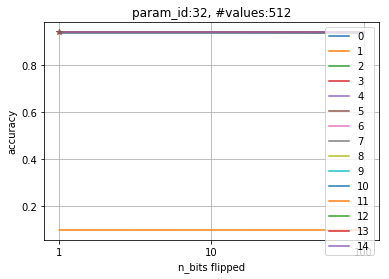

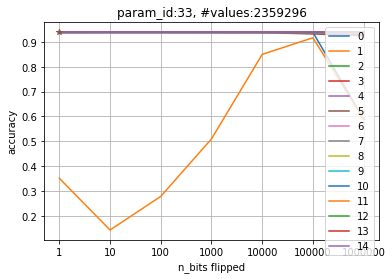

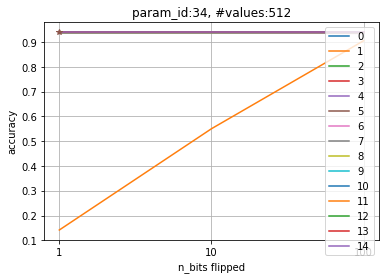

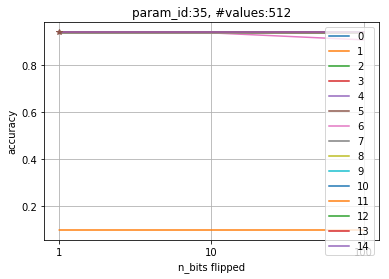

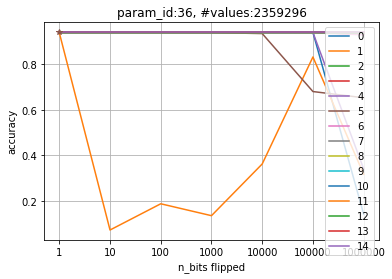

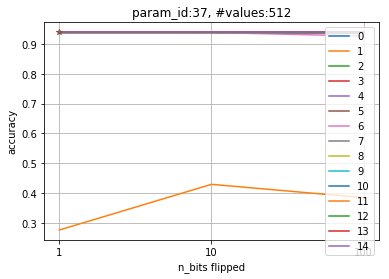

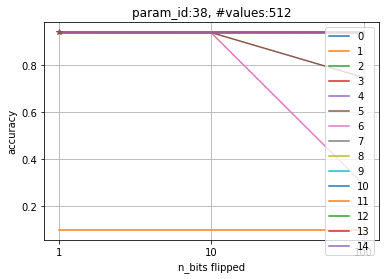

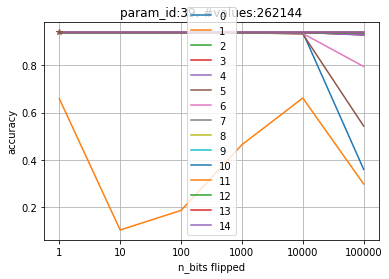

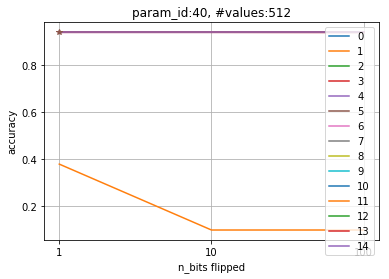

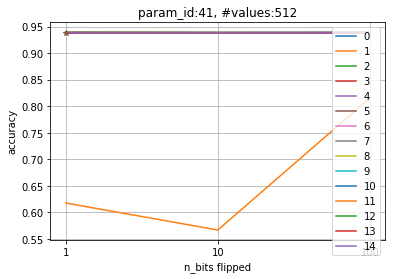

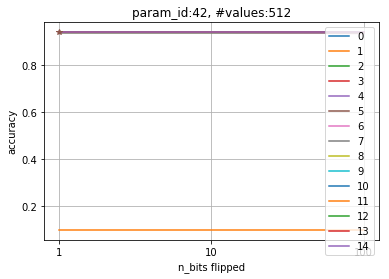

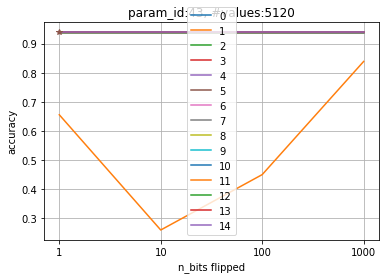

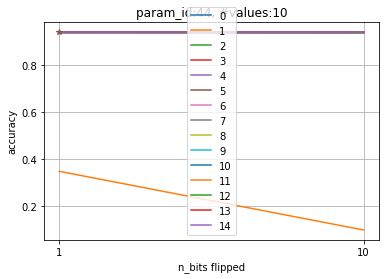

In [44]:
# compare same param_id, same bit_position, x: n_bits, y: accuracy 
for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        
        for param_id in sorted(data[model_type][fault_type].keys()):
            bit_positions = sorted(data[model_type][fault_type][param_id].keys())[:15]
            
            for bit_position in bit_positions:
                res = data[model_type][fault_type][param_id][bit_position]
                n_bits_list = sorted(res.keys())
                accuracies = [np.average(res[n_bits], axis=0)[2] for n_bits in n_bits_list]
                
                plt.plot(range(len(n_bits_list)), accuracies, label=str(bit_position))
            plt.legend()    
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
            plt.grid()
            plt.ylabel('accuracy')
            plt.xlabel('n_bits flipped')
            plt.title('param_id:%d, #values:%d' %(param_id, res[n_bits_list[0]][0, 0]))
            plt.xticks(range(len(n_bits_list)), map(str, n_bits_list)) 
            plt.plot(fault_free_accuracy, marker='*')
            plt.show()
                

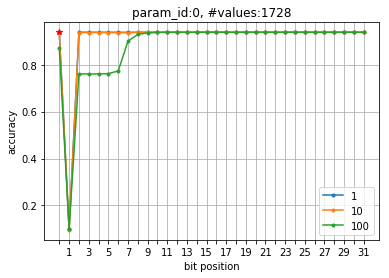

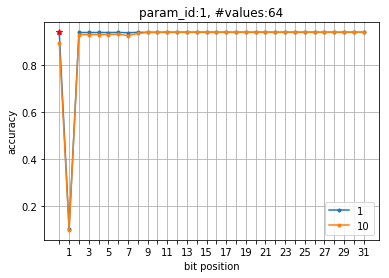

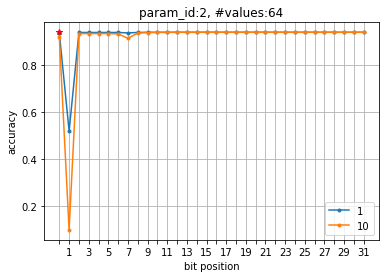

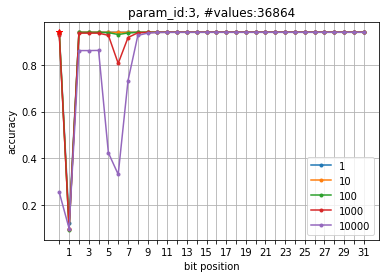

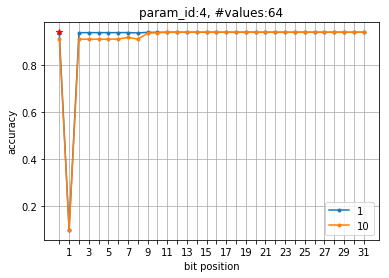

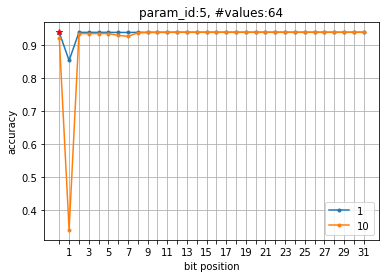

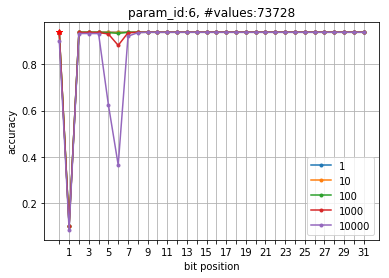

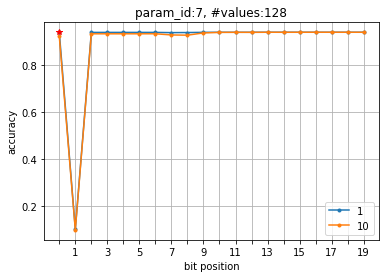

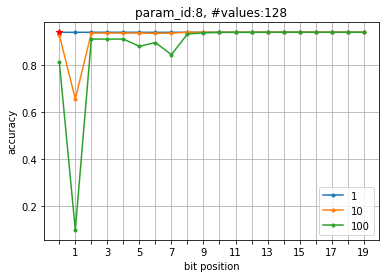

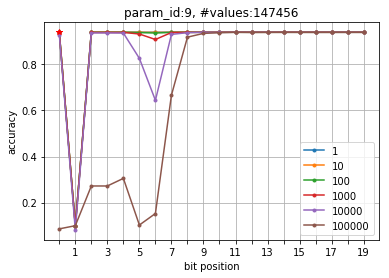

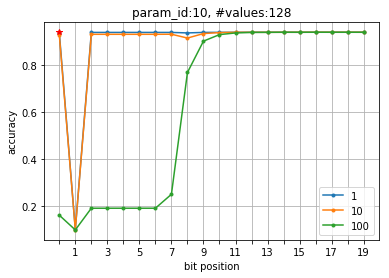

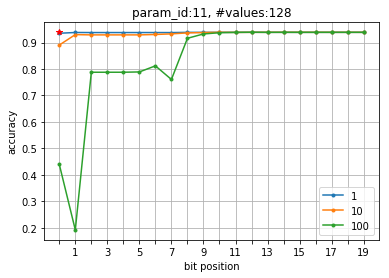

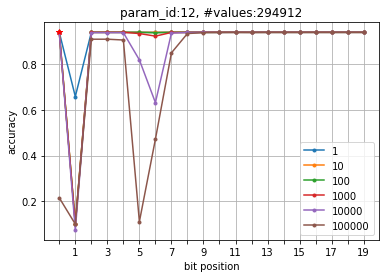

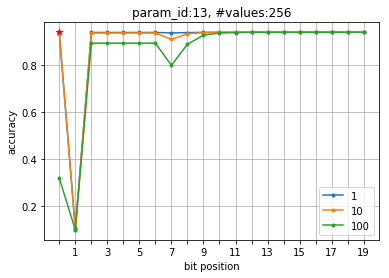

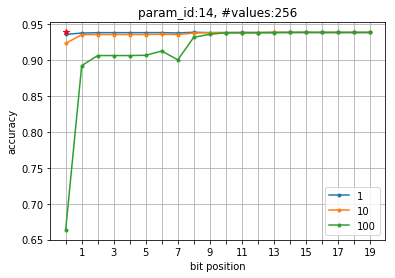

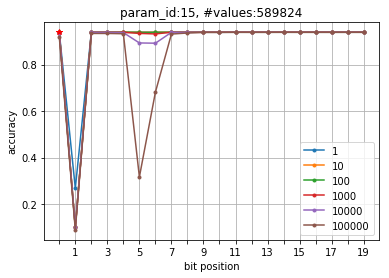

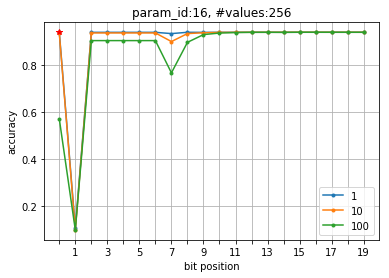

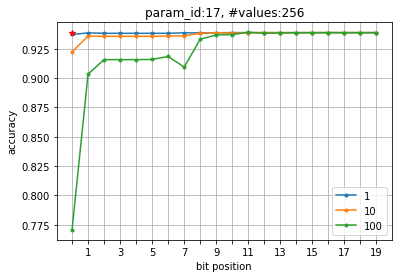

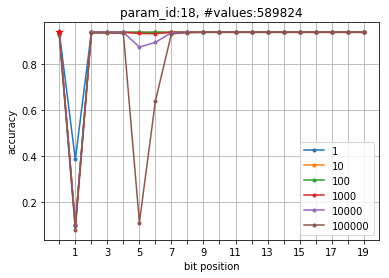

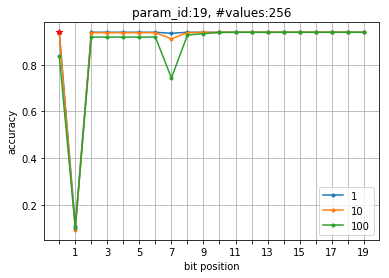

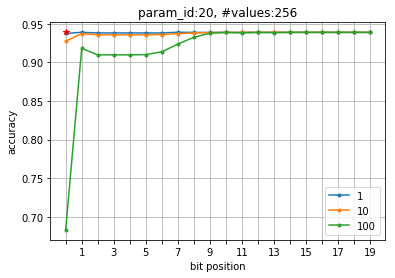

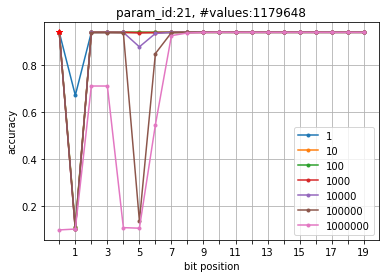

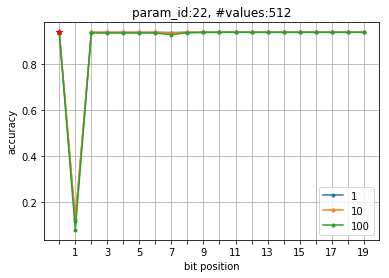

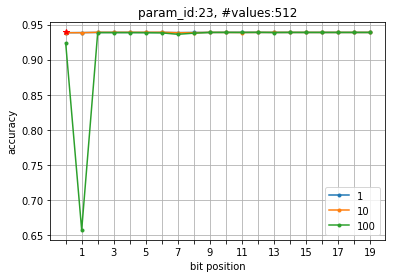

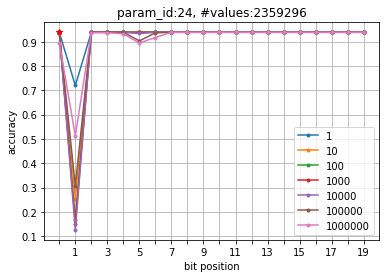

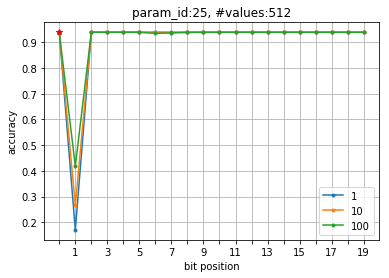

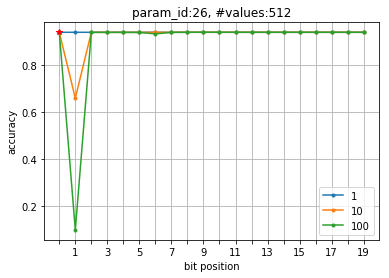

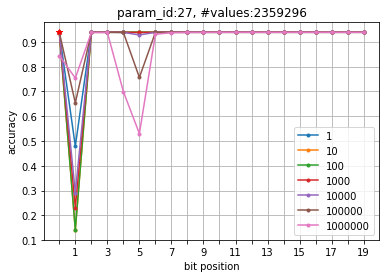

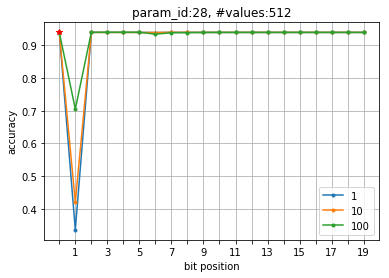

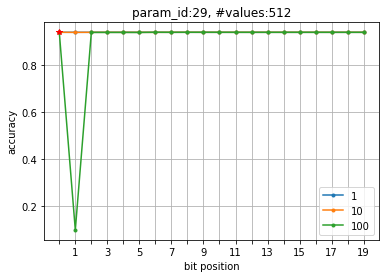

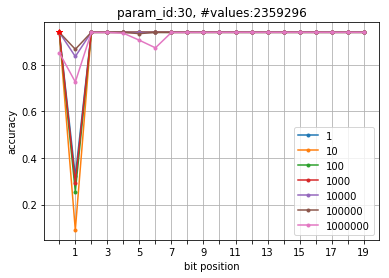

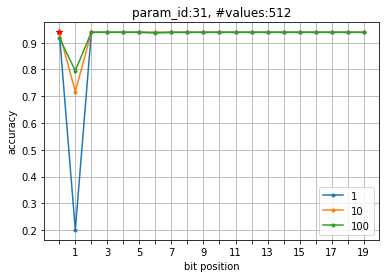

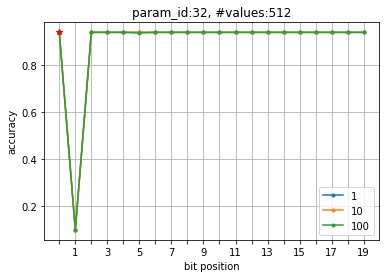

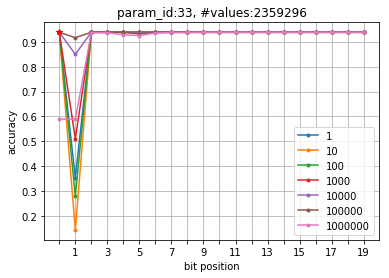

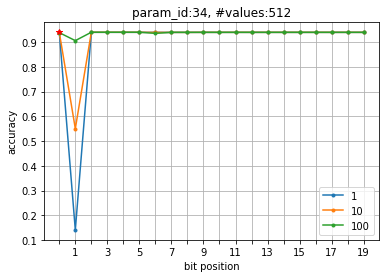

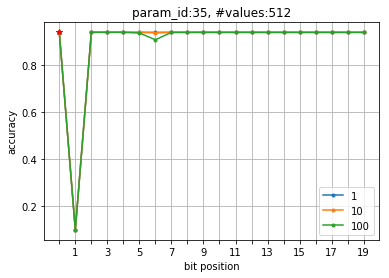

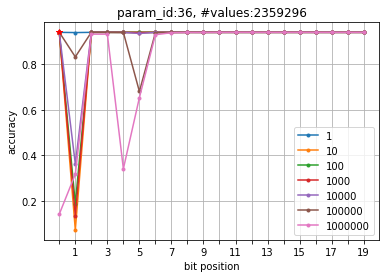

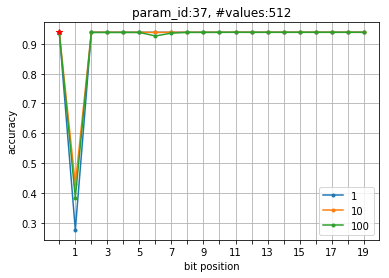

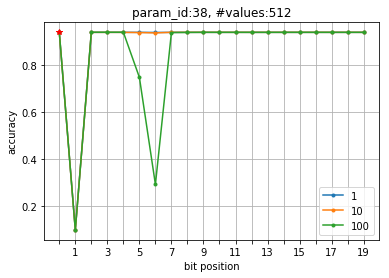

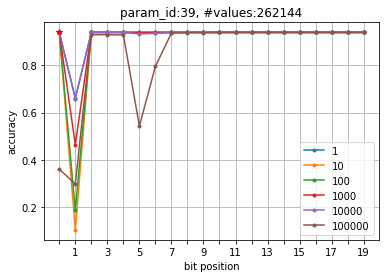

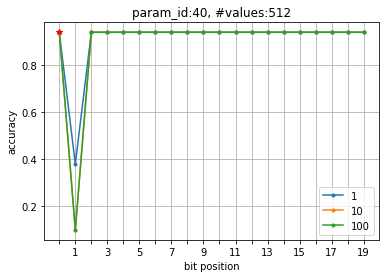

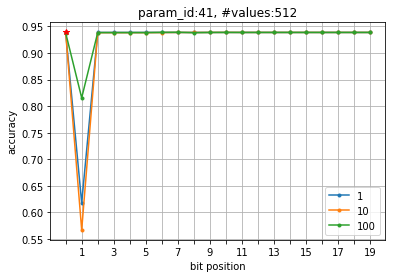

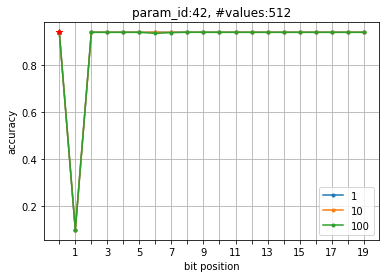

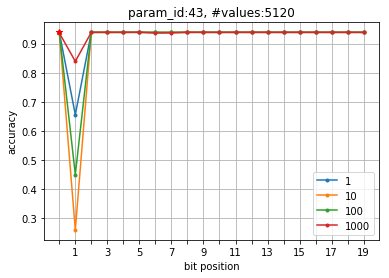

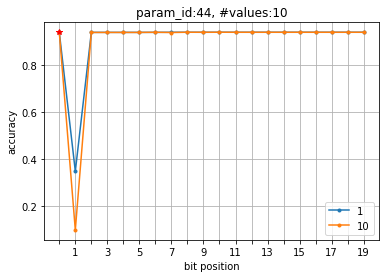

In [72]:
# compare same param_id, same n_bits, x: bit_position, y: accuracy 
for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        for param_id in sorted(data[model_type][fault_type].keys()):
            bit_positions = sorted(data[model_type][fault_type][param_id].keys())
            n_bits_list = sorted(data[model_type][fault_type][param_id][0].keys())
            
            for n_bits in n_bits_list:   
                res = data[model_type][fault_type][param_id]
                accuracies = [np.average(res[bit_position][n_bits], axis=0)[2] for bit_position in bit_positions]
                plt.plot(bit_positions, accuracies, marker='.', label=str(n_bits))
                
            plt.legend()    
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
            plt.grid()
            plt.ylabel('accuracy')
            plt.xlabel('bit position')
            plt.title('param_id:%d, #values:%d' %(param_id, res[0][1][0, 0])) # 0: bit position; 1: n_bits 
            plt.xticks(range(len(bit_positions)), map(str, [x if x%2 else '' for x in bit_positions ]))
            plt.plot(fault_free_accuracy, marker='*', color='r')
            plt.show()
                

In [69]:
import pickle 
def load_pickle(load_path, load_name=None, verbose=False):
    if load_name:
        filepath =  os.path.join(load_path, load_name)
    else:
        filepath = load_path 
    if verbose:
        print('Load pickle file:', filepath)
    return pickle.load( open(filepath, "rb" ))

def parse_stats(stats):
    # input format:
    # stats = {param_name: {value: [(flipped bit position, bit value after flip, value after flip)]}}
    # output format: 
    # param_name: #values changed,  #0 -> 1 bit flips, # 1-> 0 bit flips 
    param_stats = {'changed_params':0, 
                               'flip_to_one': np.zeros(32), 
                               'flip_to_zero': np.zeros(32),
                              'value_before_flip': [],
                              'value_after_flip':[], 
                              'flipped_positions': []}
            
    for value_id, flip_list in stats.items():
        param_stats['changed_params'] += 1
        param_stats['value_before_flip'].append(round(flip_list[0][0], 6))
        param_stats['value_after_flip'].append(round(flip_list[-1][-1], 6))
        param_stats['flipped_positions'].append([x[1] for x in flip_list])

        for _, flip_pos, flip_bit, flip_value in flip_list:
            if flip_bit:
                param_stats['flip_to_one'][flip_pos] += 1
            else:
                param_stats['flip_to_zero'][flip_pos] += 1
    return param_stats 

def trial_id_to_stats_files(trial_id):
    return str(trial_id)+'.pkl' 

def load_and_average_stats(results_dir, trial_ids):
    stat_dir = os.path.join(results_dir, 'stats')
    stats_files = map(trial_id_to_stats_files, trial_ids)
    avg_param_stats = None 
    for f in stats_files:
        # each trial is saved as a pickle 
        stats = load_pickle(stat_dir, f)
#         print(stats)
         
        param_stats = parse_stats(stats)
        if avg_param_stats:
            for key, value in param_stats.items():
                avg_param_stats[key] += value 
        else:
            avg_param_stats = param_stats
    return avg_param_stats
                    

In [83]:

model_type = 'full'
fault_type = 'faults_layer'
param_id = 38
bit_position = 5
n_bits = 100

folder = 'param-%d/bit-%d/nbits-%d' %(param_id, bit_position, n_bits)
results_dir = os.path.join(get_results_dir(model_name, dataset_name, model_type, fault_type), folder)

avg_params_stats = load_and_average_stats(results_dir, [0, 1, 2]) 
plt.bar(avg_params_stats['flip_to_one'])
plt.title('flip to one')
plt.show()

plt.bar(avg_params_stats['flip_to_zero'])
plt.title('flip to zero')

plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_after_flip'], 'o')
plt.xlabel('value_before_flip')
plt.ylabel('value_after_flip')


TypeError: bar() missing 1 required positional argument: 'height'

In [62]:
import torch 
import models

def load_checkpoint(model, model_path):
    if model_path:
        if os.path.isfile(model_path):
            print("=> loading checkpoint '{}'".format(model_path))
            checkpoint = torch.load(model_path)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(model_path, checkpoint['epoch'], best_prec1))
        else:
            raise ValueError("=> no checkpoint found at '{}'".format(model_path))
    else:
        raise ValueError('model_path cannot be empty!')
    return best_prec1 
arch = 'vgg'
depth = 16 
model_path = './logs/vgg16/cifar10/model_best.pth.tar'
checkpoint = torch.load(model_path)
model = models.__dict__[arch](dataset=dataset_name, depth=depth, cfg=checkpoint['cfg'])
best_prec1 = load_checkpoint(model, model_path)


=> loading checkpoint './logs/vgg16/cifar10/model_best.pth.tar'
=> loaded checkpoint './logs/vgg16/cifar10/model_best.pth.tar' (epoch 158) Prec1: 0.938800


(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00, 3.00000e+00,
        5.00000e+00, 9.00000e+00, 7.00000e+00, 1.80000e+01, 4.30000e+01,
        4.30000e+01, 5.90000e+01, 8.50000e+01, 1.71000e+02, 3.51000e+02,
        6.47000e+02, 1.50200e+03, 3.65100e+03, 1.00940e+04, 3.60250e+04,
        1.32486e+05, 4.80170e+04, 1.54710e+04, 6.46400e+03, 3.02900e+03,
        1.62700e+03, 8.61000e+02, 4.84000e+02, 2.81000e+02, 2.19000e+02,
        1.19000e+02, 9.40000e+01, 6.60000e+01, 4.90000e+01, 3.20000e+01,
        2.50000e+01, 2.00000e+01, 1.60000e+01, 1.20000e+01, 3.00000e+00,
        9.00000e+00, 4.00000e+00, 3.00000e+00, 1.00

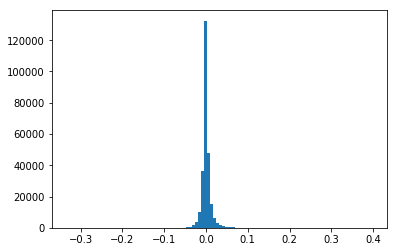

In [84]:
param_id = 39
plt.hist(list(model.parameters())[param_id].data.cpu().numpy().ravel(), bins=100)